In [115]:
# Main notebook for the project
import requests
import warnings
from bs4 import BeautifulSoup
import os
import re
import pandas as pd
from urllib.parse import urljoin
import shutil
import numpy as np
from datetime import datetime
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score, davies_bouldin_score
warnings.filterwarnings('ignore')

def create_folder_if_not_exists(folder_name):
    if not os.path.exists(folder_name):
        os.makedirs(folder_name)

def save_dataset(df, folder, file_name):
    create_folder_if_not_exists(folder)
    file_path = os.path.join(folder, file_name)
    df.to_csv(file_path, index=False)

def download_file(url, folder):
    file_name = url.split('/')[-1]
    file_path = os.path.join(folder, file_name)
    response = requests.get(url)
    if response.status_code == 200:
        with open(file_path, 'wb') as file:
            file.write(response.content)
    else:
        print(f"Failed to download the file. Status code: {response.status_code}")        

def find_data_start_row(file_path):
    with open(file_path, 'r') as file:
        for i, line in enumerate(file):
            if line.startswith("   "):
                return i
    return 0

def extract_links(url, href_contains):
    urls = []
    try:
        response = requests.get(url)
        if response.ok:
            soup = BeautifulSoup(response.text, 'html.parser')
            links = soup.find_all('a', href=True)
            for link in links:
                if href_contains in link['href']:
                    full_url = urljoin(url, link['href'])
                    urls.append(full_url)
        else:
            print(f"Error accessing page: Status code {response.status_code}")
    except requests.RequestException as e:
        print(f"Error during requests to {url} : {str(e)}")
    
    return urls

def download_main_dataset(url, output_folder, pattern):
    timestamp_suffix = datetime.now().strftime("_%Y%m%d_%H%M%S")
    output_folder_with_timestamp = f"{output_folder}{timestamp_suffix}"
    csv_links = extract_links(url, pattern)
    create_folder_if_not_exists(output_folder_with_timestamp)

    for link in csv_links:
        # Pass the modified folder path with the timestamp to the download function
        download_file(link, output_folder_with_timestamp)
        
def txt_to_csv(file_path, output_folder):    #Dataset 1
    start_row = find_data_start_row(file_path)
    df = pd.read_csv(file_path, skiprows=start_row, delim_whitespace=True, usecols=[0, 1, 2, 3, 4, 5, 6])
    df.reset_index(drop=True, inplace=True)
    file_name = os.path.basename(file_path)
    output_file = os.path.join(output_folder, file_name.replace('.txt', '.csv'))
    df.to_csv(output_file, index=False)
    return output_folder

def convert_txts_to_csvs(input_folder, output_folder):    #Dataset 1
    create_folder_if_not_exists(output_folder)
    for file in os.listdir(input_folder):
        file_path = os.path.join(input_folder, file)
        if file_path.endswith('.txt'):
            txt_to_csv(file_path, output_folder)

def clean_and_rename_csv_in_folder(input_folder, output_folder, remove_rows_criteria=[], special_chars_to_remove=[]):   #Dataset 1
    create_folder_if_not_exists(output_folder)
    for file_name in os.listdir(input_folder):
        file_path = os.path.join(input_folder, file_name)
        if file_path.endswith('.csv'):
            df = pd.read_csv(file_path)
            df = df.drop(0).reset_index(drop=True)
            df.columns = ['yyyy', 'mm', 'tmax (degC)', 'tmin (degC)', 'af (days)', 'rain (mm)', 'sun (hours)']
            df.replace('---', pd.NA, inplace=True)
            for criterion in remove_rows_criteria:
                for col_name, value in criterion.items():
                    df = df[df[col_name] != value]
            for col in df.columns:
                if df[col].dtype == 'object':
                    for char in special_chars_to_remove:
                        df[col] = df[col].str.replace(char, "", regex=True)
            output_file_path = os.path.join(output_folder, file_name)
            df.to_csv(output_file_path, index=False)

def extract_and_save_coordinates(input_folder, output_folder):  #Dataset 1
    create_folder_if_not_exists(output_folder)
    for file_name in os.listdir(input_folder):
        file_path = os.path.join(input_folder, file_name)
        if file_path.endswith('.txt'):
            with open(file_path, 'r') as file:
                text = file.read()
            lat_lon_pattern = re.compile(r'Lat\s*([+-]?\d+\.\d+)\s*Lon\s*([+-]?\d+\.\d+)')
            matches = lat_lon_pattern.findall(text)
            if matches:
                latest_lat, latest_lon = matches[-1]
            else:
                latest_lat, latest_lon = None, None
            df = pd.DataFrame({
                'File Name': [file_name],
                'Latitude': [latest_lat],
                'Longitude': [latest_lon]
            })
            output_file_name = os.path.splitext(file_name)[0] + '_coordinates.csv'
            output_file_path = os.path.join(output_folder, output_file_name)
            df.to_csv(output_file_path, index=False)

def process_happiness_excel(file_path, sheet_name, word):   #Dataset 2
    # Load the CSV data, ignoring the first column which is just an index
    data = pd.read_excel(file_path, sheet_name=sheet_name, header=None, skiprows=2)

    col_names = [
        "Codes", "Area names", "Region", "Location", "Total % 0-4", "Total % 5-6", "Total % 7-8", "Total % 9-10", 
        "Total Average rating", "Total Standard deviation", "0-4 CV", "0-4 Lower limit", "0-4 Upper limit", 
        "5-6 CV", " 5-6 Lower limit", "5-6 Upper limit", "7-8 CV", "7-8 Lower limit", "7-8 Upper limit", 
        "9-10 CV", "9-10 Lower limit", "9-10 Upper limit", "Total CV", "Total Lower limit", "Total Upper limit", 
        "Sample size"
    ]
    for i in range(len(data)):
        if word in str(data.iloc[i, 0]):
            data.columns = data.iloc[i]
            data = data.iloc[i+1:]
            break
    data = data.dropna(how="all")
    data.reset_index(drop=True, inplace=True)
    data.columns = data.columns.str.strip()
    if "2012" in file_path:
        new_columns = col_names
    else:
        del col_names[9]
        new_columns = col_names
    data.columns = new_columns[:len(data.columns)]

    return data

def process__excel_folder(input_folder, output_folder, sheet_name, word):   #Dataset 2
    create_folder_if_not_exists(output_folder)
    for filename in os.listdir(input_folder):
        if filename.endswith(".xls"):
            file_path = os.path.join(input_folder, filename)
            updated_filename = filename[:-3] + "xlsx"
            updated_file_path = os.path.join(input_folder, updated_filename)
            shutil.copy(file_path, updated_file_path)
            updated_file_path = os.path.join(input_folder, updated_filename)
            processed_data = process_happiness_excel(updated_file_path, sheet_name, word)
            output_file_path = os.path.join(output_folder, filename.replace(".xls", ".csv"))
            processed_data.to_csv(output_file_path, index=False)

def clean_census_rows(input_folder, output_folder):   #Dataset 2
    create_folder_if_not_exists(output_folder)
    for file_name in os.listdir(input_folder):
        file_path = os.path.join(input_folder, file_name)
        if file_path.endswith('.csv'):
            df = pd.read_csv(file_path)
            df = df[~df['Codes'].str.contains(' ', na=True)]
            df.replace('x', np.nan, inplace=True)
            df.replace('#', np.nan, inplace=True)
            df.replace('x ', np.nan, inplace=True)
            output_file_path = os.path.join(output_folder, file_name)
            df.to_csv(output_file_path, index=False)

def combine_dataset_2_average(input_folder, output_folder, drop_columns=["Total Standard deviation"], no_group=False):
    all_codes_dfs = []
    
    # Step 1: Collect 'Codes' from each file
    for file_name in os.listdir(input_folder):
        if file_name.endswith('.csv'):
            file_path = os.path.join(input_folder, file_name)
            df = pd.read_csv(file_path)
            df.replace('x', np.nan, inplace=True)
            all_codes_dfs.append(df[['Codes']].drop_duplicates())
    
    # Step 2: Find distinct 'Codes'
    distinct_codes_df = pd.concat(all_codes_dfs).drop_duplicates().reset_index(drop=True)
    
    all_data_dfs = []
    for file_name in os.listdir(input_folder):
        if file_name.endswith('.csv'):
            file_path = os.path.join(input_folder, file_name)
            df = pd.read_csv(file_path)
            df.replace('x', np.nan, inplace=True)
            df = df.drop(columns=drop_columns, errors='ignore')
            all_data_dfs.append(df)
    
    # Concatenate all DataFrames vertically and sort by 'Codes'
    concatenated_df = pd.concat(all_data_dfs, axis=0).sort_values(by='Codes')
    concatenated_df["Sample size"] = concatenated_df["Sample size"].astype(float)

    # If no_group is True, skip the grouping and averaging process
    if no_group:
        final_df = concatenated_df
    else:
        # Step 5: Compute final values based on your criteria
        def compute_final_values(group):
            numeric_cols = group.select_dtypes(include=np.number).columns
            non_numeric_cols = group.select_dtypes(exclude=np.number).columns.drop('Codes')

            # For numeric columns, calculate mean
            group[numeric_cols] = group[numeric_cols].mean()

            # For non-numeric columns, keep the first value
            group[non_numeric_cols] = group[non_numeric_cols].apply(lambda x: x.dropna().head(1).item() if not x.dropna().empty else np.nan)

            return group.head(1)

        final_df = concatenated_df.groupby('Codes', as_index=False).apply(compute_final_values).reset_index(drop=True)

    # Ensure the output folder exists
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Define the output file path within the output folder
    output_file_path = os.path.join(output_folder, "combined_dataset.csv" if not no_group else "merged_dataset.csv")

    # Save the final DataFrame
    final_df.to_csv(output_file_path, index=False)

def impute_missing_values(file_path, columns_to_impute, group_by=None):
    df = pd.read_csv(file_path)
    
    if group_by:
        for col in columns_to_impute:
            df[col] = df.groupby(group_by)[col].transform(lambda x: x.fillna(x.mean()))
    else:
        for col in columns_to_impute:
            df[col] = df[col].fillna(df[col].mean())
    
    return df

def impute_missing_values_in_folder(input_folder, output_folder, columns_to_impute, group_by=None):
    create_folder_if_not_exists(output_folder)
    for file_name in os.listdir(input_folder):
        file_path = os.path.join(input_folder, file_name)
        if file_path.endswith('.csv'):
            try:
                df = impute_missing_values(file_path, columns_to_impute, group_by)
                output_file_path = os.path.join(output_folder, file_name)
                df.to_csv(output_file_path, index=False)
            except Exception as e:
                print(f"Error occurred in file: {file_name}")
                print(str(e))

def generate_weather_dataset(input_folder, use_station_average=True):
    all_data = []

    for file_name in os.listdir(input_folder):
        file_path = os.path.join(input_folder, file_name)
        if file_path.endswith('.csv'):
            station_name = os.path.splitext(file_name)[0].replace("data", "")
            df = pd.read_csv(file_path)

            if use_station_average:
                df_avg = df[['tmax (degC)', 'tmin (degC)', 'af (days)', 'rain (mm)', 'sun (hours)']].apply(pd.to_numeric, errors='coerce').mean().to_frame().T
                df_avg['station'] = station_name  # Add station name
                all_data.append(df_avg)
            else:
                df = df.drop(columns=['yyyy']).apply(pd.to_numeric, errors='coerce', axis=0)
                df_monthly_avg = df.groupby('mm').mean().reset_index()
                df_monthly_avg['station'] = station_name
                all_data.append(df_monthly_avg)

    # Combine all dataframes into one
    final_df = pd.concat(all_data, ignore_index=True)
    return final_df

def find_elbow_point(wcss):
    # Calculate the second derivative of the wcss list
    second_derivative = np.diff(wcss, n=2)
    # The elbow point is where the second derivative is maximum (in absolute value)
    elbow_point = np.argmax(np.abs(second_derivative)) + 2  # Adding 2 because np.diff reduces the length by 1 for each differentiation
    return elbow_point

def apply_clustering(df, num_clusters_range, optimal_num_clusters=None):
    numerical_cols = df.select_dtypes(include=[np.number]).columns
    X = df[numerical_cols]
    
    scaler = StandardScaler().fit(X)
    X_scaled = scaler.transform(X)

    wcss = []
    silhouette_scores = []
    davies_bouldin_scores = []

    for n_clusters in num_clusters_range:
        kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10).fit(X_scaled)
        labels = kmeans.labels_
        wcss.append(kmeans.inertia_)
        
        if n_clusters > 1:  # These metrics require at least 2 clusters to be meaningful
            silhouette_scores.append(silhouette_score(X_scaled, labels))
            davies_bouldin_scores.append(davies_bouldin_score(X_scaled, labels))

    # Visualizing the metrics to help determine the optimal number of clusters
    plt.figure(figsize=(18, 5))
    
    # Plot WCSS
    plt.subplot(1, 3, 1)
    plt.plot(num_clusters_range, wcss, marker='o', linestyle='-', color='blue')
    plt.title('Elbow Method (WCSS)')
    plt.xlabel('Number of clusters')
    plt.ylabel('WCSS')
    
    # Plot Silhouette Score
    plt.subplot(1, 3, 2)
    plt.plot(num_clusters_range[1:], silhouette_scores, marker='o', linestyle='-', color='green')
    plt.title('Silhouette Score')
    plt.xlabel('Number of clusters')
    plt.ylabel('Silhouette Score')
    
    # Plot Davies-Bouldin Score
    plt.subplot(1, 3, 3)
    plt.plot(num_clusters_range[1:], davies_bouldin_scores, marker='o', linestyle='-', color='red')
    plt.title('Davies-Bouldin Score')
    plt.xlabel('Number of clusters')
    plt.ylabel('Davies-Bouldin Score')
    
    plt.tight_layout()
    plt.show()

    optimal_num_clusters = optimal_num_clusters if optimal_num_clusters else find_elbow_point(wcss)

    # Apply clustering with the chosen optimal number of clusters
    kmeans_optimal = KMeans(n_clusters=optimal_num_clusters, random_state=42, n_init=10).fit(X_scaled)
    df['cluster'] = kmeans_optimal.labels_
    
    return df


Dataset 1 Download and Schema Enforcement

In [90]:
# Download and convert the files for dataset 1
output_folder_ds1_txt = '../data/ds1/landing/stations_txt'
output_folder_ds1_csv = '../data/ds1/landing/stations_csv'
output_folder_ds1_csv_clean = '../data/ds1/bronze/stations_csv_clean'
station_url = 'https://www.metoffice.gov.uk/research/climate/maps-and-data/historic-station-data'
pattern_station = '.txt'

download_main_dataset(station_url, output_folder_ds1_txt, pattern_station)
convert_txts_to_csvs(output_folder_ds1_txt, output_folder_ds1_csv)
clean_and_rename_csv_in_folder(output_folder_ds1_csv, output_folder_ds1_csv_clean, [{'yyyy': "Site"}], ['#', '\*', 'Change', '\$', 'all'])

# Extract and save coordinates
output_folder_ds1_coordinates = '../data/ds1/reference/locations'
extract_and_save_coordinates(output_folder_ds1_txt, output_folder_ds1_coordinates)

Dataset 2 Download and Schema Enforcement

In [91]:
# Download and convert the files for dataset 2
output_folder_ds2_xlsx = '../data/ds2/landing/census_xlsx'
output_folder_ds2_csv = '../data/ds2/landing/census_csv'
output_folder_ds2_csv_clean = '../data/ds2/bronze/census_csv_clean'
output_folder_ds2_csv_combined ='../data/ds2/bronze/census_csv_combined'
census_url = "https://www.ons.gov.uk/peoplepopulationandcommunity/wellbeing/datasets/personalwellbeingestimatesgeographicalbreakdown"
pattern_census = 'tcm'
create_folder_if_not_exists(output_folder_ds2_csv_combined)
download_main_dataset(census_url, output_folder_ds2_xlsx, pattern_census)
process__excel_folder(output_folder_ds2_xlsx, output_folder_ds2_csv, 'Happiness', 'Codes')
clean_census_rows(output_folder_ds2_csv, output_folder_ds2_csv_clean)
combine_dataset_2_average(output_folder_ds2_csv_clean, output_folder_ds2_csv_combined, no_group=False)

Datset 1 Impute Missing Values

In [92]:
output_folder_ds1_csv_clean = '../data/ds1/bronze/stations_csv_clean'
output_folder_ds1_csv_clean_imputed = '../data/ds1/silver/stations_csv_clean_imputed'
columns_to_impute = ["mm", "tmax (degC)", "tmin (degC)", "af (days)", "rain (mm)", "sun (hours)"]

impute_missing_values_in_folder(output_folder_ds1_csv_clean, output_folder_ds1_csv_clean_imputed, columns_to_impute, group_by="mm")

Part 1

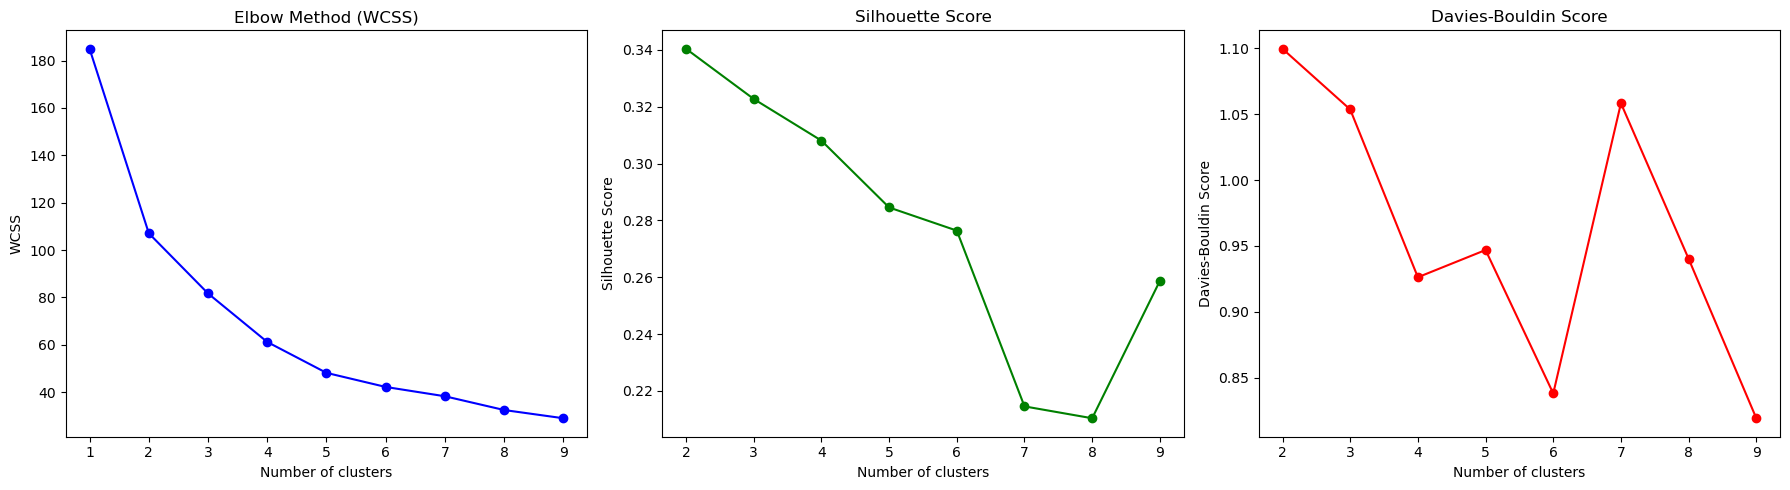

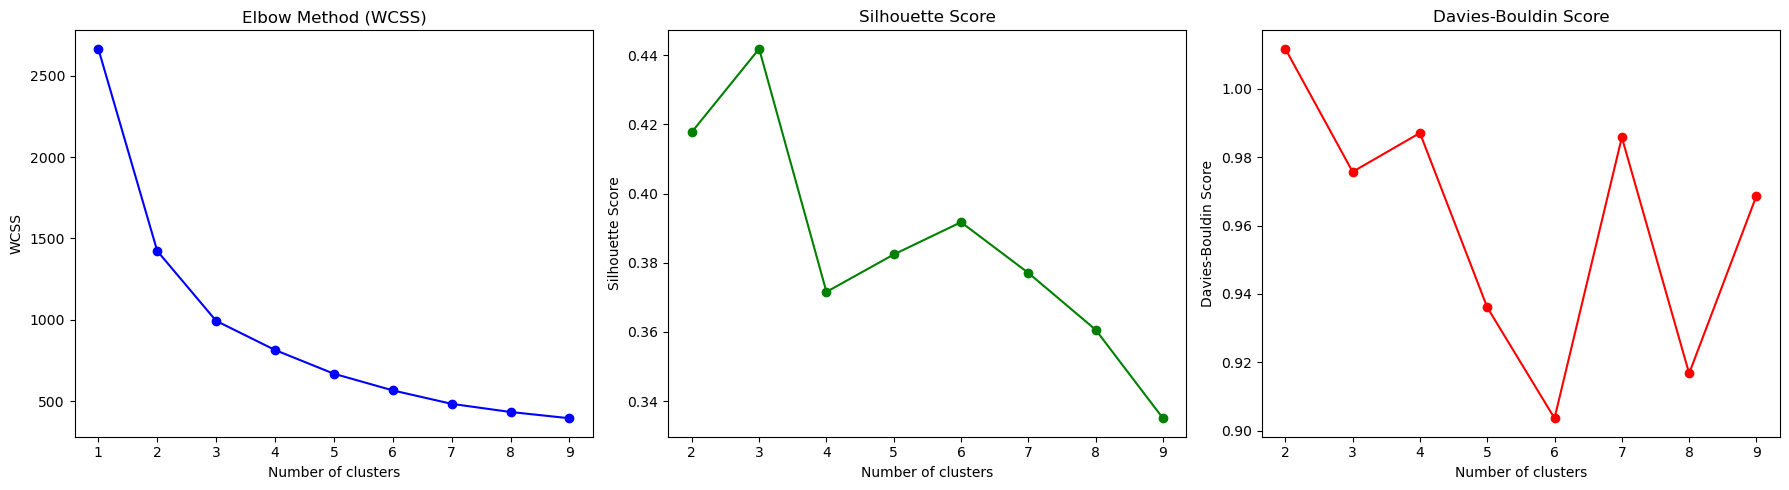

In [117]:
output_folder_ds1_csv_clean_imputed = '../data/ds1/silver/stations_csv_clean_imputed'
output_folder_clustering_df = '../data/ds1/silver/clustering_datasets'
stations_total_average_file_name = 'stations_total_average.csv'
stations_monthly_file_name = 'stations_monthly_average.csv'

stations_total_average_df = generate_weather_dataset(output_folder_ds1_csv_clean_imputed, use_station_average=True)
stations_monthly_average_df = generate_weather_dataset(output_folder_ds1_csv_clean_imputed, use_station_average=False)

save_dataset(stations_total_average_df, output_folder_clustering_df, stations_total_average_file_name)
save_dataset(stations_monthly_average_df, output_folder_clustering_df, stations_monthly_file_name)

stations_total_average_df_labeled = apply_clustering(stations_total_average_df, range(1, 10), optimal_num_clusters=3)
stations_monthly_average_df_labeled = apply_clustering(stations_monthly_average_df, range(1, 10), optimal_num_clusters=3)